# **Dependancy**

In [ ]:
pip install deepxde

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.layers 

from google.colab import files
import io

import tensorboard
from datetime import datetime

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tensorflow.python.keras.utils.vis_utils import plot_model

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


# **Prepare Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Jumps to the desired directory
%cd 'drive/My Drive/Analytical Data'
p1 = genfromtxt('T_q100_v200_T25_D100.csv', delimiter=',')
times = genfromtxt('time.csv', delimiter=',')
times = times.reshape((100,1))
times.shape
times[0:5]
points = p1[:, 1:3]
points.shape
temps = p1[:, 5:]
temps.shape
train_number = 1681
num_p = 1681
# test_number = 10 * 100

/content/drive/My Drive/Analytical Data


Re-arranging

In [5]:
all_ = []

for j in range(100):
  new_points = np.zeros((1681, 3))
  for i in range(1681):
      new_points[i] = [points[i][0], points[i][1], times[j] * 1000] # y, z, t , ??  +  np.random.normal() ??
  all_.append(new_points)

new_temps = temps[:,:]
new_temps.shape

(1681, 100)

**Non-randomized**

In [6]:
new_points=new_points[0:num_p,:]
new_temps = new_temps[0:num_p,:]

### Now we have an input of size 168100 by 3 and output of size 168100 by 1

In [7]:
train_x = new_points[0:train_number]
train_y = new_temps[0:train_number]
test_x = new_points[train_number:]
test_y = new_temps[train_number:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1681, 3)
(1681, 100)
(0, 3)
(0, 100)


# **Model and PINN**

**Checking the path**

In [ ]:
import os
cwd = os.getcwd()
print(cwd)

/content/drive/My Drive/Analytical Data


**Defining Required functions**

In [8]:
# defining the pde
def pde(x, y):
  dy_x = tf.gradients(y, x)[0]
  dy_x1, dy_x2, dy_t = dy_x[:, 0:1], dy_x[:, 1:2], dy_x[:, 2:]
  dy_x1x1 = tf.gradients(dy_x1, x)[0][:, 0:1]
  dy_x2x2 = tf.gradients(dy_x2, x)[0][:, 1:2]
  return (dy_t - (dy_x1x1 - dy_x2x2))

def func(x):
  return np.full((len(x), 1), 10e-2)

def funcic(x): return np.full((len(x), 1), 25)

def funcbc(x):  # x = the collection of the points on the boundary 
  result = np.zeros((len(x), 1))
  for i in range(len(x)):
    result[i] = map_dict[(x[i][0], x[i][1], x[i][2])]  # 0: y, 1: z, 2 : time
  return result

def solution(x) :
  result = np.zeros((len(x), 1))
  for i in range(len(x)):
    result[i] = map_dict[(x[i][0], x[i][1], x[i][2])]  # 0: y, 1: z, 2 : time
  return result

**Defining Required Variables**

In [9]:
models = []
train_x = all_[0][0:train_number]
train_y = new_temps[0:train_number, 0].reshape((1681,1))
map_dict =  {}

# early stopping
callback = dde.callbacks.EarlyStopping(min_delta=0.001, patience=3000)

# defining the geometry
geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# defining the model
layer_size = [3] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

**Retraining Step**

In [ ]:
checkpoint_path = "model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [11]:
for time_step in range(100):

  # preparing data for this specific time step
  train_x = all_[time_step][0:train_number]
  train_y = new_temps[0:train_number, time_step].reshape((1681,1))
  map_dict =  {}
  for i in range(len(train_x)):
    map_dict[(train_x[i][0], train_x[i][1], train_x[i][2])] = train_y[i]

  # defining the boundary and initial conditions
  bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
  ic = dde.IC(geomtime, funcic, lambda _, on_initial: on_initial)


  # defining the data in deepxde format
  data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_boundary = 0, num_domain = 0, anchors = train_x, solution = solution)

  print("Time Step :", time_step)
  
    # In the first time-step, just store the model. In the following ones, first restre, then train and then store again.

  if time_step == 0:
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001,metrics=["l2 relative error"])
    losshistory, train_state = model.train(epochs=6000)
    model.saver.save(model.sess, "model/model1")
  else:
    model.data = data
    model.saver.restore(model.sess, "model/model1")
    model.compile("adam", lr=0.001,metrics=["l2 relative error"])
    losshistory, train_state = model.train(epochs=6000)
    model.saver.save(model.sess, "model/model1")

Time Step : 0
Compiling model...
'compile' took 0.718959 s

Initializing variables...
Training model...

0         [2.26e-03, 2.72e+03, nan]         [2.26e-03, 0.00e+00, 0.00e+00]    [1.01e+00]    
1000      [3.19e-08, 9.62e+02, nan]         [3.19e-08, 0.00e+00, 0.00e+00]    [4.72e-01]    
2000      [1.43e-08, 8.67e+02, nan]         [1.43e-08, 0.00e+00, 0.00e+00]    [4.66e-01]    
3000      [5.56e-08, 8.66e+02, nan]         [5.56e-08, 0.00e+00, 0.00e+00]    [4.70e-01]    
4000      [2.65e-02, 2.98e+02, nan]         [2.65e-02, 0.00e+00, 0.00e+00]    [2.53e-01]    
5000      [1.84e-02, 9.19e+01, nan]         [1.84e-02, 0.00e+00, 0.00e+00]    [1.72e-01]    
6000      [2.81e-02, 2.83e+01, nan]         [2.81e-02, 0.00e+00, 0.00e+00]    [1.47e-01]    

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 34.176462 s

INFO:tensorflow:model/model1 is not in all_model_checkpoint_paths. Manually adding it.
Time Step : 1
INFO:tensorflow:Restoring parameters from 

KeyboardInterrupt: ignored

In [12]:
model.data.train_points()

array([[ 1.    ,  1.    ,  2.0304],
       [ 2.    ,  1.    ,  2.0304],
       [ 3.    ,  1.    ,  2.0304],
       ...,
       [39.    , 41.    ,  2.0304],
       [40.    , 41.    ,  2.0304],
       [41.    , 41.    ,  2.0304]])

In [13]:
model.data.train_x[0:5]

array([[1.    , 1.    , 2.0304],
       [2.    , 1.    , 2.0304],
       [3.    , 1.    , 2.0304],
       [4.    , 1.    , 2.0304],
       [5.    , 1.    , 2.0304]])

In [14]:
train_x[0:5]

array([[1.    , 1.    , 2.0304],
       [2.    , 1.    , 2.0304],
       [3.    , 1.    , 2.0304],
       [4.    , 1.    , 2.0304],
       [5.    , 1.    , 2.0304]])

**Finding Boundary**

In [ ]:
import deepxde as dde
def func(x):
  return np.full((len(x), 1), 10e-2)
geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
#geom = dde.geometry.geometry_2d.Polygon([(0, 0), (0, 40), (41, 41), (41, 0)])
timedomain = dde.geometry.TimeDomain(0, 0.01) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
# bc = PointSetBC(train_x, train_y)
bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
# bc = dde.boundary_conditions.PointSet(train_x)

In [ ]:
boundary = bc.collocation_points(train_x)
temps_on_boundary = np.zeros((len(boundary), 1))
for i in range(len(boundary)):
  temps_on_boundary[i] = map_dict[(boundary[i][0], boundary[i][1], boundary[i][2])] 
all_boundary = np.concatenate((boundary, temps_on_boundary), axis = 1)

**Plotting Boundary**

In [ ]:
all_boundary.shape

(103, 4)

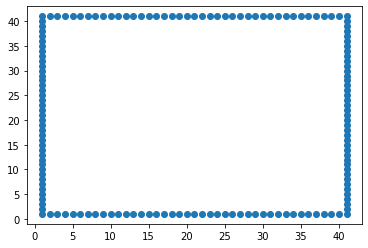

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(all_boundary[:,0], all_boundary[:,1]) 

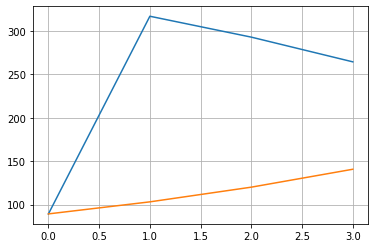

In [ ]:
times = [i for i in range(4)]
predictions = []
actuals = []
point_number = 10
for i in range(4):
  predictions.append(preds[i][point_number])
  actuals.append(new_temps[point_number][i])

fig, ax = plt.subplots()
ax.plot(times, predictions)
ax.plot(times, actuals)
plt.grid()